# DTW-Based Cleaning of Gait Database

This notebook :
1. Load patient time-series via Data_loader
2. Compute DTW distance matrix across segments.
3. Summarize distances and flag outlier segments.
4. Reconstruct a cleaned dataset.
5. Display the DTW's histograms per patient (before a/o clenned - compares)


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import json
os.chdir('..')
sys.path.insert(0, os.getcwd())
from DTW import dtw_not_segmented
from Data_loader import base_folders
output_base = "DTW"
os.makedirs(output_base, exist_ok=True)
import matplotlib.pyplot as plt

In [2]:
# Run DTW‐DI for each group
#groups = ["G01", "G03"]
groups = ["G03"]
all_stats = {}
for grp in groups:
    print(f"\n=== Processing DTW-DI for group {grp} ===")
    df_stats = dtw_not_segmented(
        group_code   = grp,
        output_base  = output_base,
        verbose      = True,
        signal_col='Ankle Dorsiflexion RT (deg)',
        downsample_factor=4,
    )
    all_stats[grp] = df_stats
    


=== Processing DTW-DI for group G03 ===


Patients: 100%|██████████| 35/35 [31:42<00:00, 54.35s/it]

[OK] Saved DTW results JSON to DTW/dtw_not_segmented_G03.json
[OK] Saved DTW results CSV to DTW/dtw_not_segmented_G03.csv


In [4]:
# Inspect the saved intra-trial DTW results 
csv_path  = os.path.join(output_base, 'dtw_intra_trial_stats.csv')
json_path = os.path.join(output_base, 'dtw_intra_trial_stats.json')

print("CSV preview:")
display(pd.read_csv(csv_path).head())

#print("\nJSON preview:")
#with open(json_path, 'r') as f:
    #j = json.load(f)
# show first patient/trial entry
#first_pid = next(iter(j))
#first_trial = next(iter(j[first_pid]))
#print(first_pid, first_trial, j[first_pid][first_trial])


CSV preview:


,patient_id,trial_id,n_cycles,n_pairs,mean,median,std
0,S002,S002_G01_D01_B01_T01,200,19900,0.748373,0.735672,0.232964
1,S002,S002_G01_D01_B01_T02,198,19503,0.783071,0.700523,0.810379
2,S002,S002_G01_D01_B01_T03,195,18915,0.809434,0.713677,0.828481
3,S002,S002_G01_D01_B02_T01,196,19110,0.829126,0.727099,0.816455
4,S002,S002_G01_D01_B02_T02,199,19701,0.691586,0.682265,0.244066


In [7]:
# Define Threshold
df_stats = pd.read_csv('DTW/dtw_intra_trial_stats.csv')
mean_threshold = df_stats['mean'].quantile(0.95)
std_threshold  = df_stats['std'].quantile(0.95)

print(f"Mean DTW threshold: {mean_threshold:.2f}")
print(f"Std  DTW threshold: {std_threshold:.2f}")

# Añadir columna booleana de exclusión
df_stats['exclude'] = (df_stats['mean'] > mean_threshold) | (df_stats['std'] > std_threshold)

Mean DTW threshold: 3.20
Std  DTW threshold: 3.21


In [ ]:
# Identify Outliers
erratic_trials = df_stats[df_stats['exclude']]
print("Erratic trials detected:")
display(erratic_trials[['patient_id', 'trial_id', 'mean', 'std']])
# Exclude patients with >50% bad trials
erratic_rate = df_stats.groupby('patient_id')['exclude'].mean()
erratic_patients = erratic_rate[erratic_rate > 0.5].index.tolist()
print(f"Erratic patients (>50% bad trials): {erratic_patients}")

Erratic trials detected:


,patient_id,trial_id,mean,std
18,S003,S003_G01_D01_B01_T01,5.250938,3.767813
19,S003,S003_G01_D01_B01_T02,28.698159,15.906765
20,S003,S003_G01_D01_B01_T03,5.117581,3.545034
21,S003,S003_G01_D01_B02_T01,10.642827,6.911798
22,S003,S003_G01_D01_B02_T02,19.207070,9.426202
23,S003,S003_G01_D01_B02_T03,18.776356,12.331949
24,S003,S003_G01_D01_B03_T01,14.025793,7.565587
25,S003,S003_G01_D01_B03_T02,15.619960,7.674119
26,S003,S003_G01_D01_B03_T03,17.212334,10.397023
28,S003,S003_G01_D02_B01_T02,7.515746,6.367497


In [14]:
#Save cleaned data 
clean_df_stats = df_stats[~df_stats['exclude']].copy()
clean_df_stats = clean_df_stats[~clean_df_stats['patient_id'].isin(erratic_patients)]
clean_df_stats.to_csv('DTW/cleaned_trials.csv', index=False)

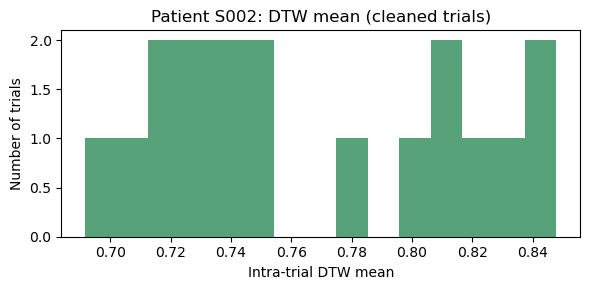

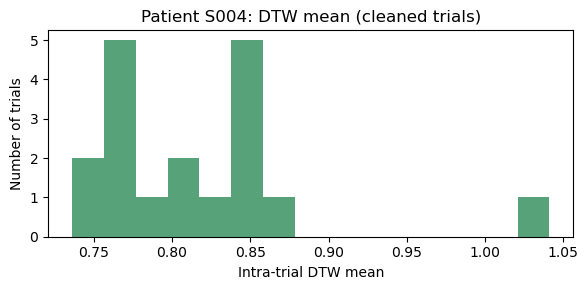

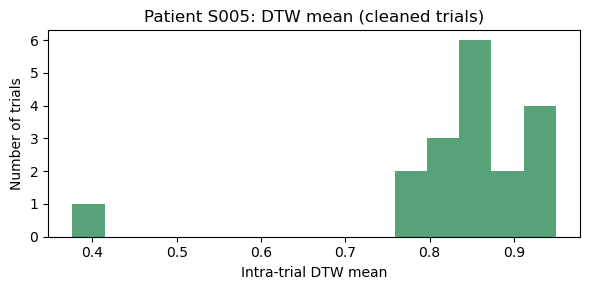

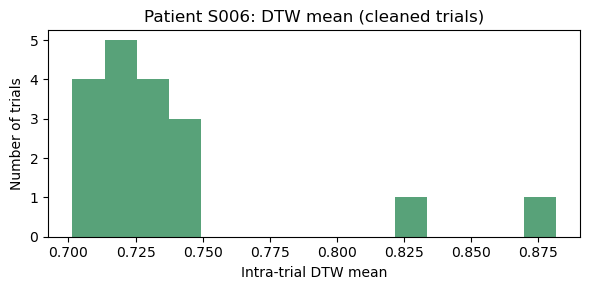

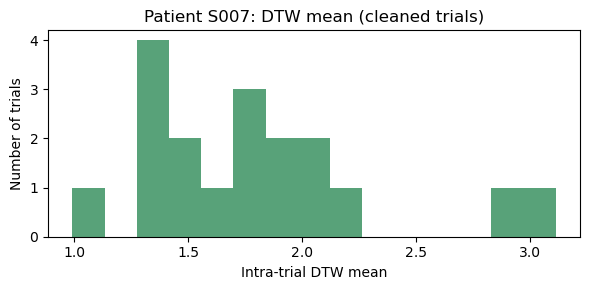

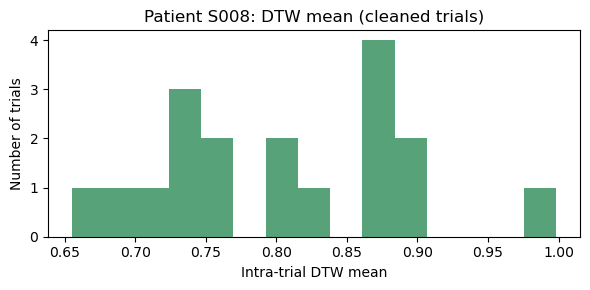

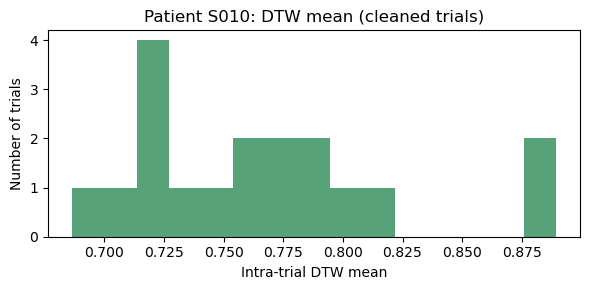

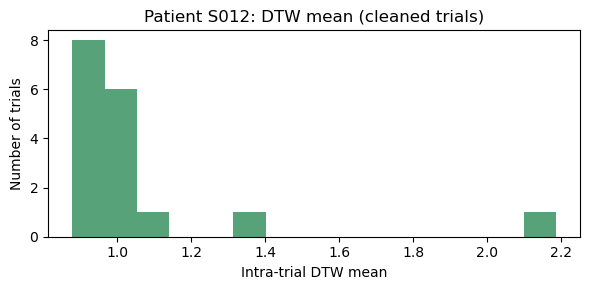

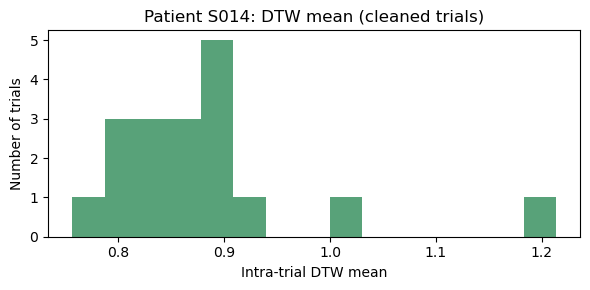

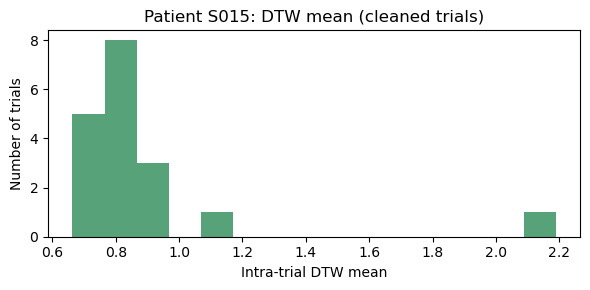

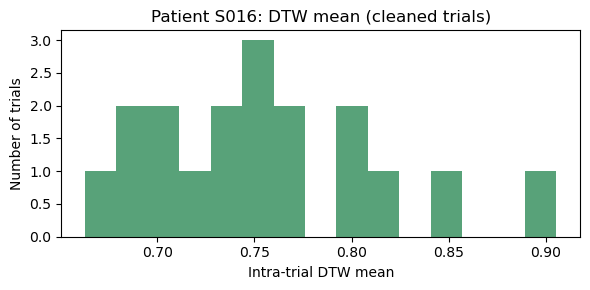

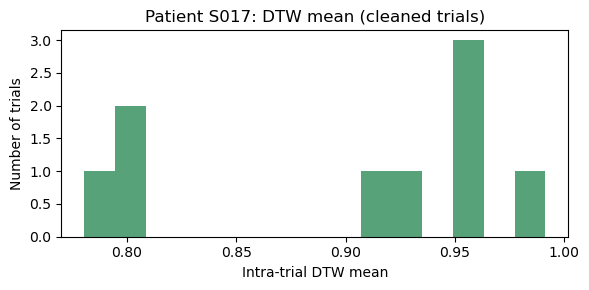

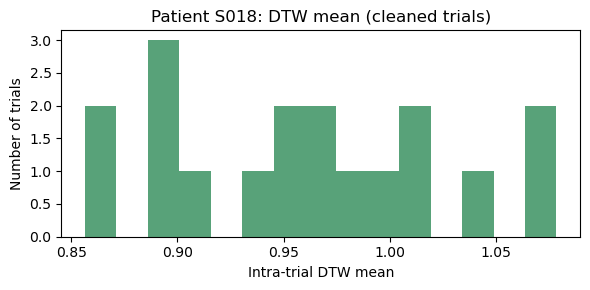

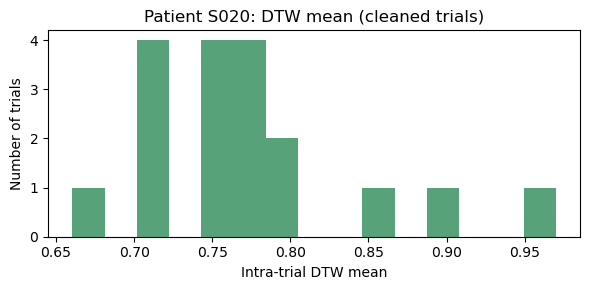

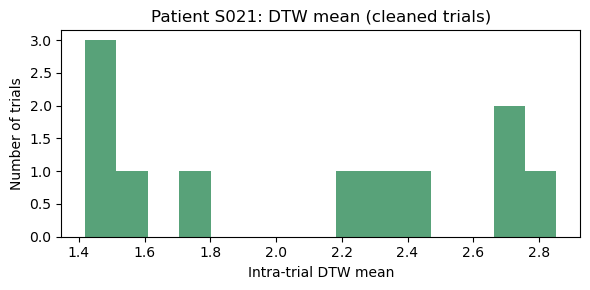

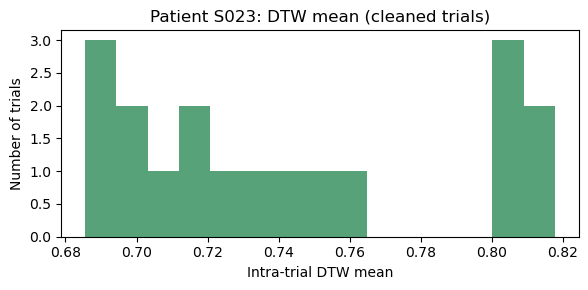

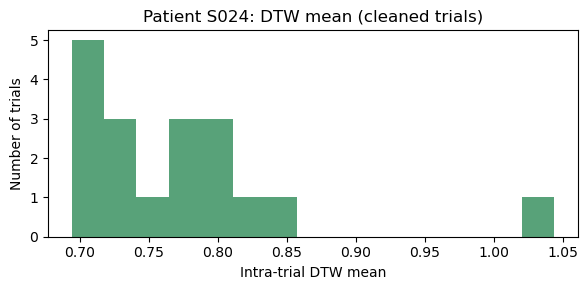

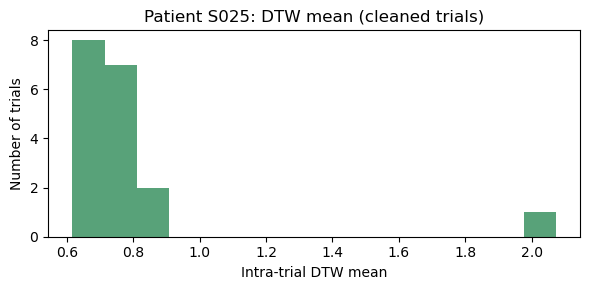

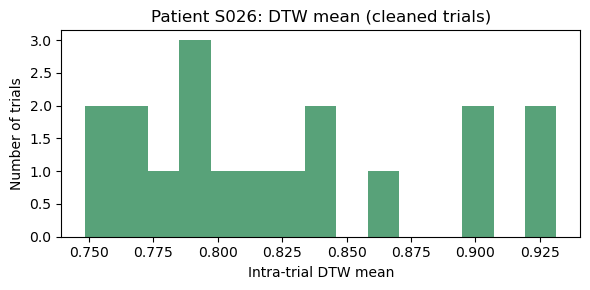

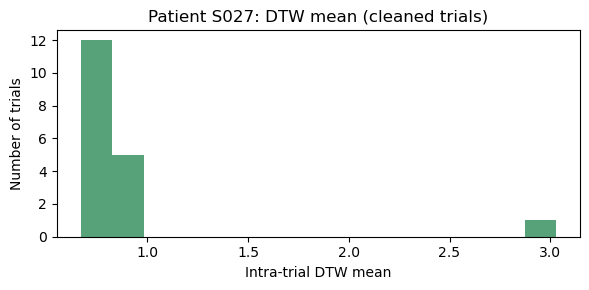

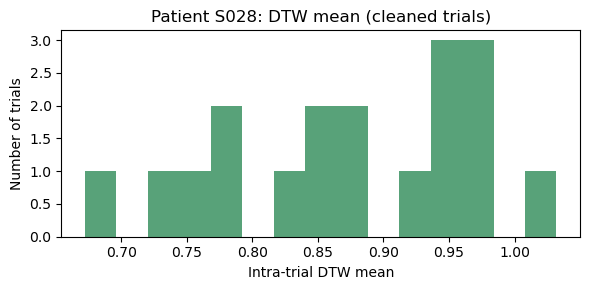

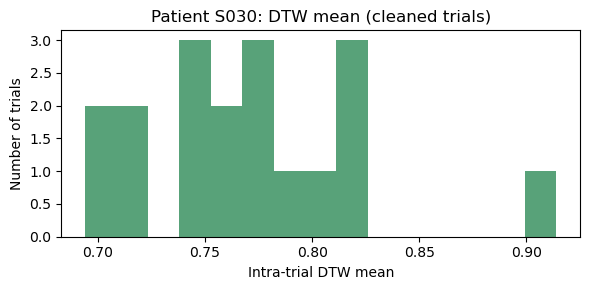

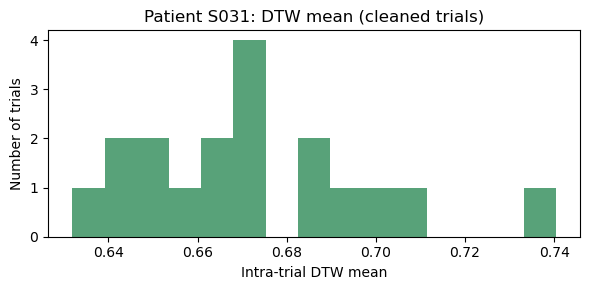

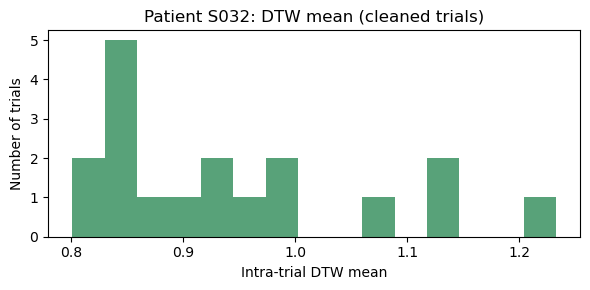

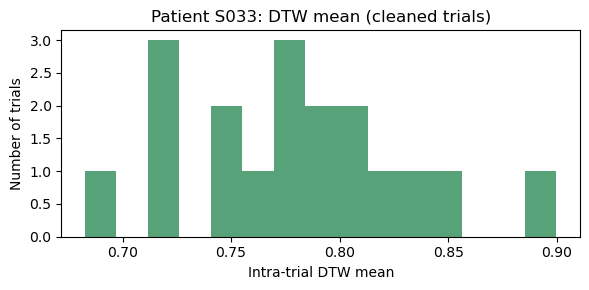

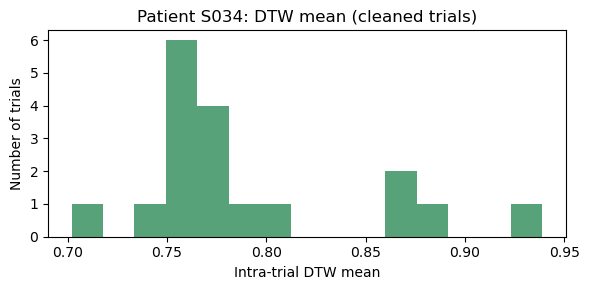

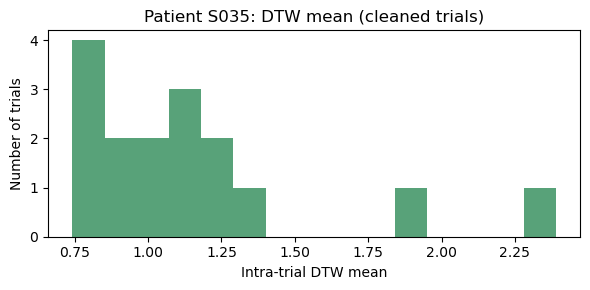

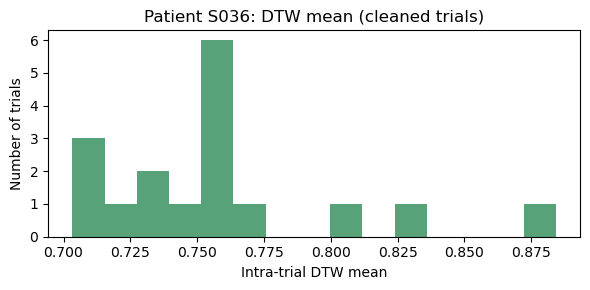

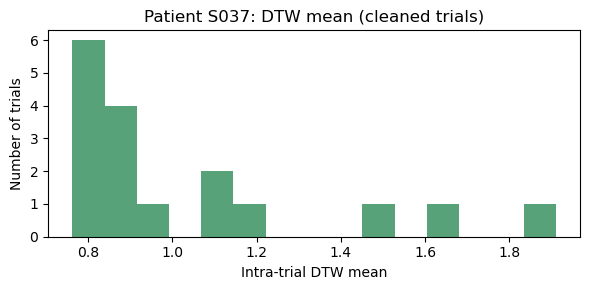

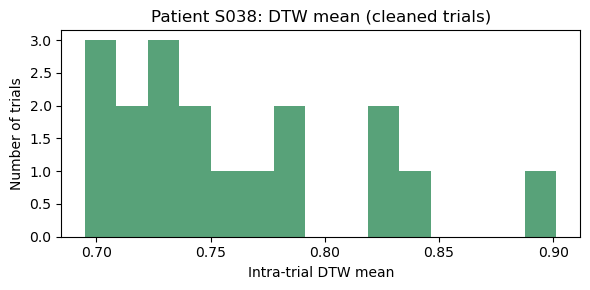

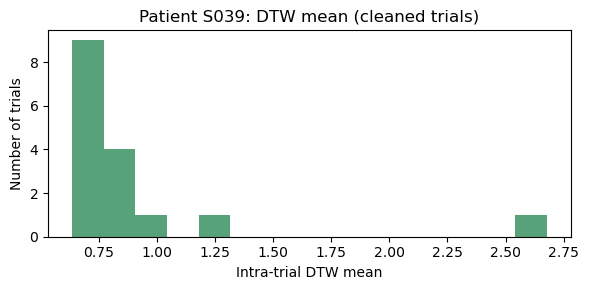

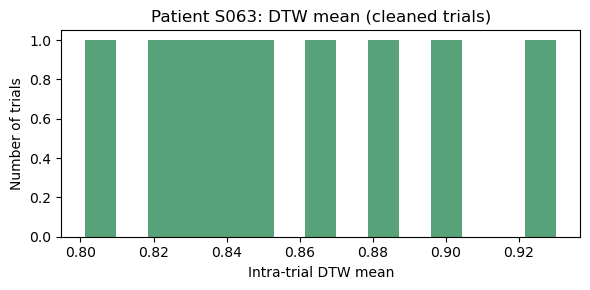

In [15]:
#DTW Histogram per patient after cleaning 
df = pd.read_csv('DTW/cleaned_trials.csv')

for pid, group in df.groupby('patient_id'):
    plt.figure(figsize=(6, 3))
    plt.hist(group['mean'].dropna(), bins=15, color='seagreen', alpha=0.8)
    plt.title(f'Patient {pid}: DTW mean (cleaned trials)')
    plt.xlabel('Intra-trial DTW mean')
    plt.ylabel('Number of trials')
    plt.tight_layout()
    plt.show()


In [ ]:
# Compare before and after cleaning 
#Allows to visualize the effect of cleaning on the DTW mean values
df_all = pd.read_csv('DTW/dtw_intra_trial_stats.csv')
df_clean = pd.read_csv('DTW/cleaned_trials.csv')

erratic_patients = df_all[df_all['exclude']]['patient_id'].unique()

for pid in erratic_patients:
    plt.figure(figsize=(8, 4))
    before = df_all[df_all['patient_id'] == pid]['mean'].dropna()
    after  = df_clean[df_clean['patient_id'] == pid]['mean'].dropna()
    plt.hist(before, bins=15, alpha=0.6, label='Before cleaning', color='salmon')
    plt.hist(after,  bins=15, alpha=0.7, label='After cleaning', color='seagreen')
    plt.title(f'Patient {pid}: DTW mean (before vs after cleaning)')
    plt.xlabel('Intra-trial DTW mean')
    plt.ylabel('Number of trials')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Compare between model patient and erratic patients 
df_clean = pd.read_csv('DTW/cleaned_trials.csv')
df_all = pd.read_csv('DTW/dtw_intra_trial_stats.csv')

# Model patient (with the lowest median DTW mean)
median_per_patient = df_clean.groupby('patient_id')['mean'].median()
modelo_pid = median_per_patient.idxmin()
modelo_means = df_clean[df_clean['patient_id'] == modelo_pid]['mean'].dropna()


erratic_patients = df_all[df_all['exclude']]['patient_id'].unique()

for pid in erratic_patients:
    plt.figure(figsize=(8, 4))
    patient_means = df_all[df_all['patient_id'] == pid]['mean'].dropna()
    plt.hist(modelo_means, bins=15, alpha=0.7, label=f'Patient Modelo: {modelo_pid}', color='royalblue')
    plt.hist(patient_means, bins=15, alpha=0.7, label=f'Erratic patient: {pid}', color='darkorange')
    plt.title(f'Comparison: Modelo vs Erratic Patient {pid}')
    plt.xlabel('Intra-trial DTW mean')
    plt.ylabel('Number of trials')
    plt.legend()
    plt.tight_layout()
    plt.show()